In [2]:
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
import seaborn as sns
import pickle

In [2]:
int2emotions = {0:'angry', 1:'fear', 2:'happy', 3:'neutral', 4:'sad', 5:'surprise'}
emotions2int = {'angry':0, 'fear':1, 'happy':2, 'neutral':3, 'sad':4, 'surprise':5}

dic = {'images':[], 'labels':[], 'purpose':[]}
    
for d in os.listdir('fer2013/'):
    print(d)
    for emotion in os.listdir(f'fer2013/{d}'):
        print(emotion)
        if emotion == 'disgust':
            continue
        for i in os.listdir(f'fer2013/{d}/{emotion}'):
            img = cv2.imread(f'fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)
            
            dic['images'].append(img)
            dic['labels'].append(emotion)
            
            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')

with open("fer2013_data.pickle", "wb") as f:
    pickle.dump(dic, f)

test
angry
disgust
fear
happy
neutral
sad
surprise
train
angry
disgust
fear
happy
neutral
sad
surprise


In [11]:
df = pd.DataFrame(dic)
df.head()

images labels purpose
0  [[[46], [34], [26], [23], [12], [32], [35], [2...  angry       V
1  [[[55], [33], [54], [32], [26], [21], [50], [2...  angry       V
2  [[[123], [123], [126], [131], [124], [69], [10...  angry       V
3  [[[255], [255], [255], [255], [255], [255], [2...  angry       V
4  [[[127], [121], [124], [137], [123], [118], [1...  angry       V

In [12]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [13]:
train_data.head()

images labels purpose
7067  [[[50], [32], [15], [11], [12], [10], [10], [8...  angry       T
7068  [[[29], [24], [29], [11], [15], [22], [26], [1...  angry       T
7069  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  angry       T
7070  [[[155], [138], [98], [112], [94], [97], [111]...  angry       T
7071  [[[211], [215], [220], [221], [219], [216], [2...  angry       T

In [14]:
val_data.head()

images labels purpose
0  [[[46], [34], [26], [23], [12], [32], [35], [2...  angry       V
1  [[[55], [33], [54], [32], [26], [21], [50], [2...  angry       V
2  [[[123], [123], [126], [131], [124], [69], [10...  angry       V
3  [[[255], [255], [255], [255], [255], [255], [2...  angry       V
4  [[[127], [121], [124], [137], [123], [118], [1...  angry       V

In [15]:
train_data['labels'].value_counts()

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
Name: labels, dtype: int64

In [16]:
val_data['labels'].value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
Name: labels, dtype: int64

In [17]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=3171)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=3171)
sad_df = train_data[train_data['labels']=='sad'].sample(n=3171)
fear_df = train_data[train_data['labels']=='fear'].sample(n=3171)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3171)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3171)

train_data = pd.concat([happy_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

images    labels purpose
0  [[[100], [122], [146], [157], [178], [189], [1...  surprise       T
1  [[[121], [128], [123], [127], [151], [140], [1...      fear       T
2  [[[185], [185], [178], [93], [37], [34], [27],...   neutral       T
3  [[[121], [127], [118], [116], [137], [154], [1...       sad       T
4  [[[172], [162], [75], [52], [65], [60], [58], ...  surprise       T

In [18]:
train_data['labels'].value_counts()

surprise    3171
fear        3171
neutral     3171
sad         3171
happy       3171
angry       3171
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='count'>

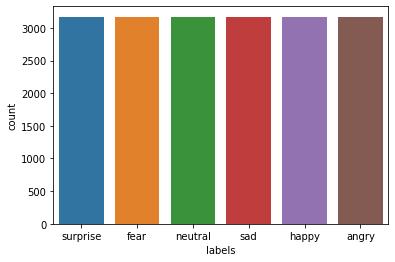

In [19]:
sns.countplot(x=train_data['labels'])

In [20]:
batch_size= 32
classes = 6
rows,columns=48,48

In [21]:
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

In [22]:
train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [23]:
train_data.shape

(19026, 48, 48, 1)

In [24]:
val_data.shape

(7067, 48, 48, 1)

## Creating Our Model

In [26]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [27]:
checkpoint = ModelCheckpoint('model\\6_class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30

# Training Our Model

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)